# Sparse NMF for Separation

One approach to using NMF for source separation is to learn sets of $k$ basis vectors $W$ and $H$ for each of the speakers in a dataset. To separate a mixture where the speakers are known, we concatenate the dictionaries $W$ associated with them, learn new loadings $H$, and take the product of the speaker-specific $W$ with the associated components of $H$ to yield the reconstruction.

Training, for speaker $i$:
$$X_i = W_i H_i$$
$$W_i, H_i = \text{NMF}(X_i)$$

Evaluation, on mixture $X_{ij}$ of speech from speaker $i$ and $j$. $\text{NMF}_W$ performs NMF updates without updating the values in $W$:
$$W_{ij} = [ W_i \, W_j ]$$
$$H_{ij}' = \text{NMF}_{W_{ij}}(X_{ij})$$
$$H_{ij}' = [ H_i' \, H_j' ]$$
$$\hat{X}_i = W_i H_i$$
$$\hat{X}_j = W_j H_j$$

In [1]:
import sys 
from itertools import islice, permutations, product
from collections import namedtuple
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

sys.path.append('../../')
from src.features.hdf5_iterator import Hdf5Iterator
from src.features.mixer import FeatureMixer
#from src.features.wav_iterator import batcher
from src.utils.tf_utils import scope_decorator as scope
from src.utils.bss_eval import bss_eval_sources
from src.factorization.nmf import snmf, nmf_separate
from src.features.spectral_features import reconstruct

num_srcs = 2
num_steps = 80
num_freq_bins = 257
num_components = 20
sparsity = 0.1

librispeech_dev = "/local_data/teams/magnolia/librispeech/processed_dev-clean.h5"
# librispeech_train = "/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5"
# librispeech_dev = "/Users/patrickc/data/LibriSpeech/processed_dev-clean.h5"

def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

%matplotlib inline

## Data
### Get speaker-specific iterators

In [2]:
%pdb off
with open("../../data/librispeech/authors/dev-clean-F.txt") as f:
    female_dev = f.read().strip().split('\n')

female_spkrs = [Hdf5Iterator(hdf5_path=librispeech_dev, speaker_keys=[dev], shape=(None,)) for dev in female_dev]
female_spkrs_slice = [Hdf5Iterator(hdf5_path=librispeech_dev, speaker_keys=[dev], shape=(num_steps,)) for dev in female_dev]

with open("../../data/librispeech/authors/dev-clean-M.txt") as f:
    male_dev = f.read().strip().split('\n')

male_spkrs = [Hdf5Iterator(hdf5_path=librispeech_dev, speaker_keys=[dev], shape=(None,)) for dev in male_dev]
male_spkrs_slice = [Hdf5Iterator(hdf5_path=librispeech_dev, speaker_keys=[dev], shape=(num_steps,)) for dev in male_dev]

Automatic pdb calling has been turned OFF


## Training

Speaker 0


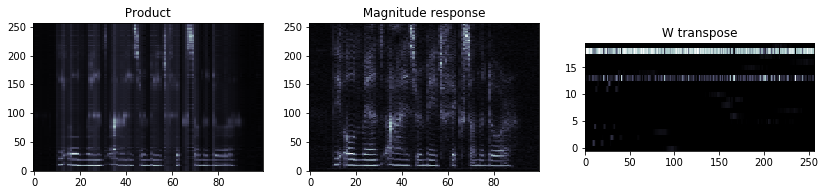

Speaker 1


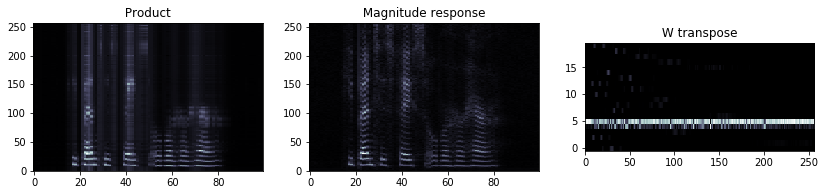

Speaker 2


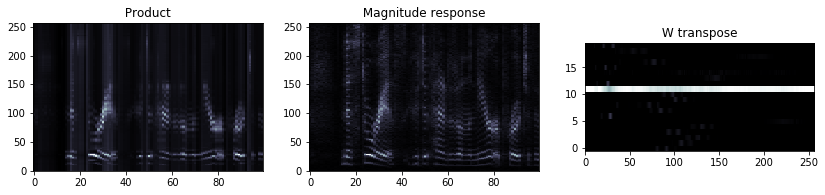

Speaker 3


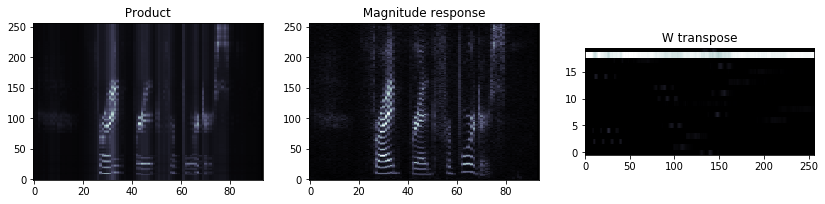

Speaker 4


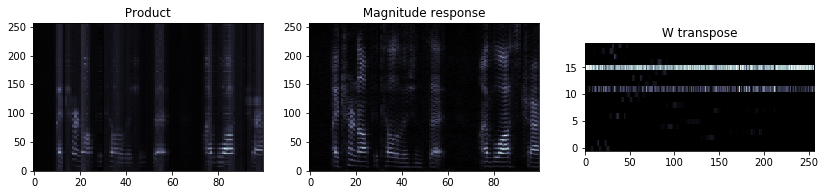

Speaker 5


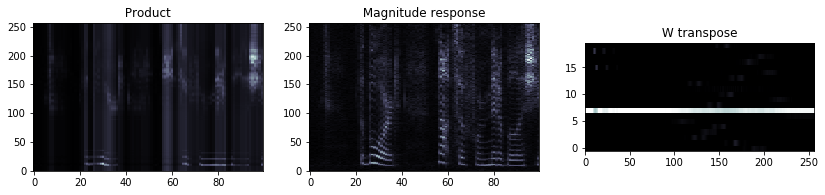

Speaker 6


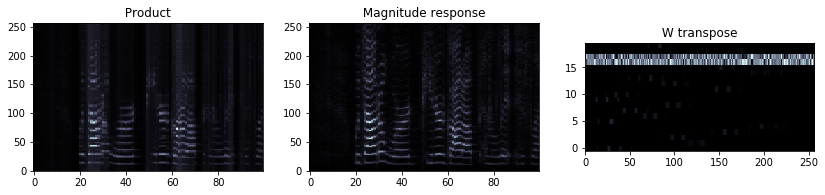

Speaker 7


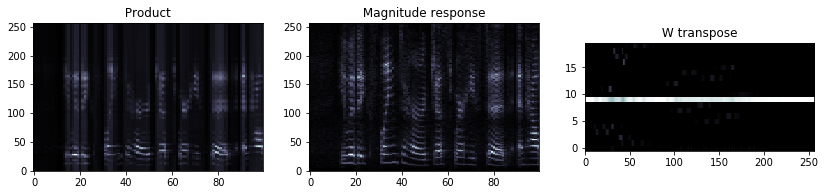

Speaker 8


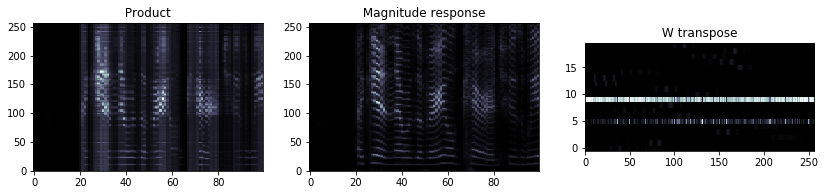

Speaker 9


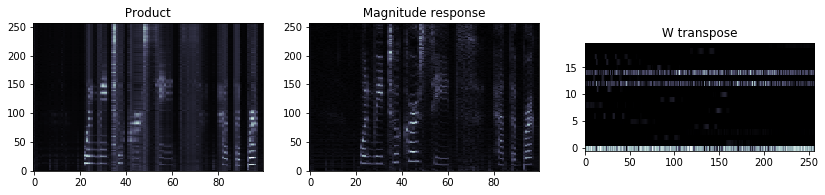

Speaker 10


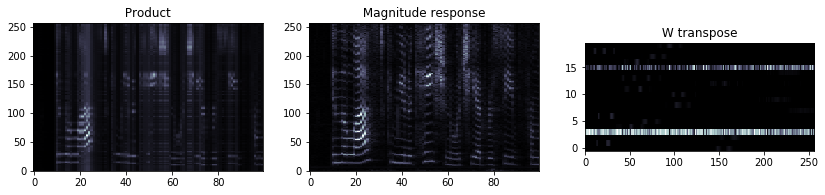

Speaker 11


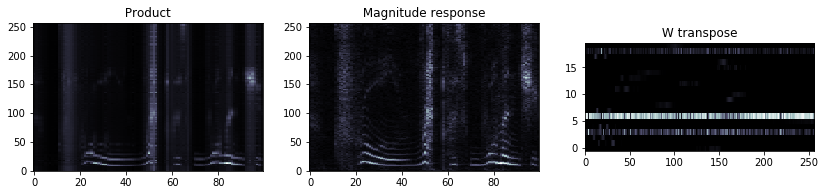

Speaker 12


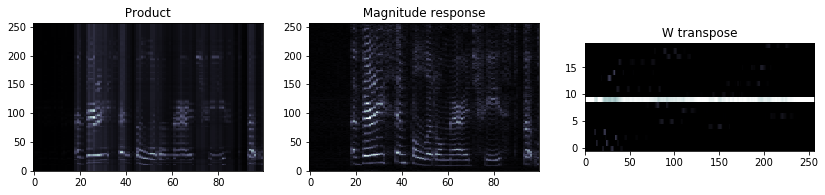

Speaker 13


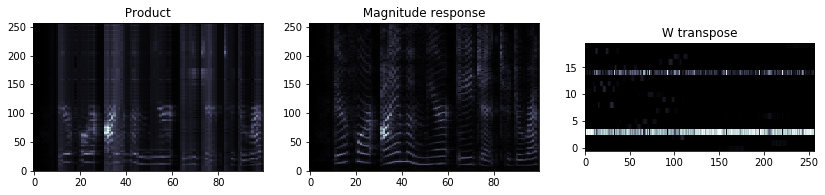

Speaker 14


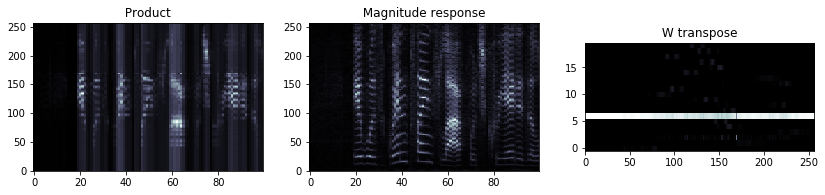

Speaker 15


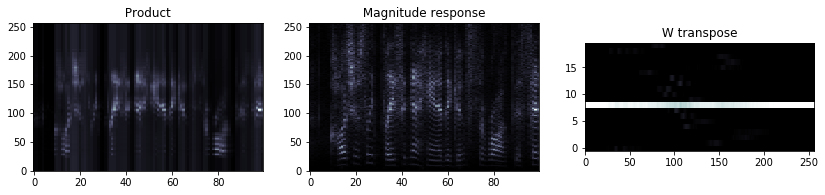

Speaker 16


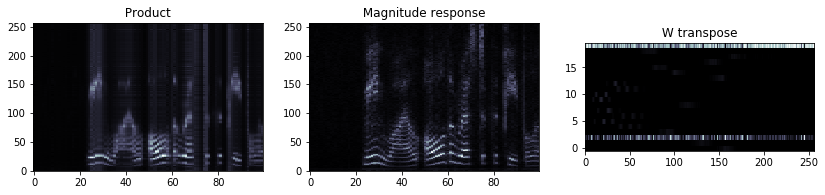

Speaker 17


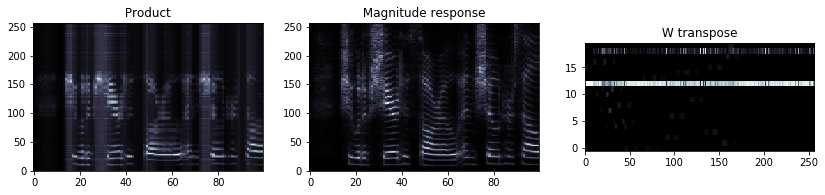

Speaker 18


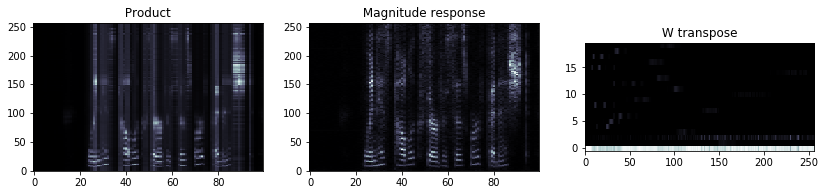

Speaker 19


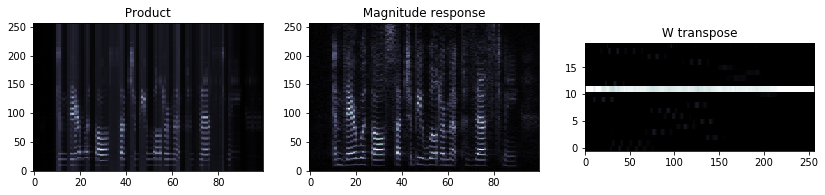

In [6]:
spkr_models = []
for i, spkr in enumerate(female_spkrs):
    print("Speaker", i)
    w = None
    for example in islice(spkr,45):
        mag, phases = scale_spectrogram(example)
        try:
            w, h = snmf(mag.T, num_components, sparsity=sparsity, num_iters=10, W_init=w)
        except ValueError:
            print("ValueError encountered", file=sys.stderr)
            continue
        
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.title(' Product ')
    plt.imshow((w @ h)[:,:100], cmap='bone', origin='lower', aspect=1/4)
    plt.subplot(1,3,2)
    plt.title(' Magnitude response ')
    plt.imshow(mag.T[:,:100], cmap='bone', origin='lower', aspect=1/4)
    plt.subplot(1,3,3)
    plt.title(' W transpose ')
    plt.imshow(w.T, cmap='bone', origin='lower', aspect=6)
    plt.show()
    spkr_models.append((w,h))

## Inference

Inference retrains just the loadings matrix $H$ in light of a given $W$ and $X$. The resulting reconstructions are qualitatively quite cruddy. Not sure what is up?

In [5]:
# Inference on women speakers
for i in range(5):
    spkr_i = np.random.randint(len(female_spkrs))
    spkr_j = np.random.randint(len(female_spkrs))
    if spkr_i == spkr_j:
        continue
    
    example_i = next(female_spkrs_slice[spkr_i])
    example_j = next(female_spkrs_slice[spkr_j])
    
    mix = example_i + example_j
    mix_scl_mag, mix_scl_phs = scale_spectrogram(mix)
    
    # separate
    reco_i, reco_j = nmf_separate(mix_scl_mag.T, [spkr_models[spkr_i], spkr_models[spkr_j]], mask=True)
    
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(mix_scl_mag.T, cmap='bone', origin='lower', aspect=1/4)
    plt.subplot(1,3,2)
    plt.imshow(reco_i, cmap='bone', origin='lower', aspect=1/4)
    plt.subplot(1,3,3)
    plt.imshow(reco_j, cmap='bone', origin='lower', aspect=1/4)
    plt.show()
    
    display.display(display.Audio(reconstruct(reco_i.T**2, mix, 10000, None, 0.0256), rate=10000))
    display.display(display.Audio(reconstruct(reco_j.T**2, mix, 10000, None, 0.0256), rate=10000))

IndexError: list index out of range

## Out-of-sample inference

Above technique only works when you know which set of basis vectors to select for each speaker.  For unseen speakers this is hard. One approach is just to pick the combination of dictionary entries that minimizes the reconstruction error. Unfortunately quadratic in the number of dictionary entries.

(Getting the cross-correlation of each basis with the mixture and picking the top two is another idea.)

(PCA on the W's also make lots of lots of sense)

In [ ]:
# Inference on men speakers
for i in range(5):
    print("Test {}".format(i))
    spkr_i = np.random.randint(len(male_spkrs))
    spkr_j = np.random.randint(len(male_spkrs))
    if spkr_i == spkr_j:
        continue
        
    example_i = next(male_spkrs_slice[spkr_i])
    example_j = next(male_spkrs_slice[spkr_j])

    mix = example_i + example_j
    mix_scl_mag, mix_scl_phs = scale_spectrogram(mix)

    # loop over choices of speaker model
    NmfSearchResult = namedtuple("NMFSearchResult", ['i', 'j', 'error', 'models', 'reconstructions'])
    optimal_pair = NmfSearchResult(0, 0, np.inf, [], [])  # i, j, error, reconstructions a and b
    for model_i in range(num_components):
        for model_j in range(model_i + 1, num_components):

            reco_i, reco_j = nmf_separate(mix_scl_mag.T, [spkr_models[model_i], spkr_models[model_j]], mask=True)
            
            err = np.mean(np.abs(mix_scl_mag.T - (reco_i + reco_j)))
            
            if err < optimal_pair.error:
                optimal_pair = NmfSearchResult(model_i, model_j, err, 
                                               [spkr_models[model_i][0], spkr_models[model_j][0]], 
                                               [reco_i, reco_j])
                
    # Display results
    print("Used weight matrices {} and {}".format(optimal_pair.i, optimal_pair.j))
    
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(mix_scl_mag.T, cmap='bone', origin='lower', aspect=1/4)
    plt.subplot(1,3,2)
   
    plt.imshow(optimal_pair.reconstructions[0], cmap='bone', origin='lower', aspect=1/4)
    plt.subplot(1,3,3)
    plt.imshow(optimal_pair.reconstructions[1], cmap='bone', origin='lower', aspect=1/4)
    plt.show()
    
    # Evaluate
    mix_audio = reconstruct(mix, mix, 10000, None, 0.0256)
    ref_i = reconstruct(example_i, example_i, 10000, None, 0.0256)
    ref_j = reconstruct(example_j, example_j, 10000, None, 0.0256)
    opt_reco_i = reconstruct(optimal_pair.reconstructions[0].T**2, mix, 10000, None, 0.0256)
    opt_reco_j = reconstruct(optimal_pair.reconstructions[1].T**2, mix, 10000, None, 0.0256)

    base_metrics =  bss_eval_sources(np.stack([ref_i, ref_j]), np.stack([mix_audio, mix_audio]))
    predicted_metrics = bss_eval_sources(np.stack([ref_i, ref_j]), np.stack([opt_reco_i, opt_reco_j]))
    print("SDR: {}, SIR: {}, SAR: {}, perm {}".format(*base_metrics))
    print("SDR: {}, SIR: {}, SAR: {}, perm {}".format(*predicted_metrics))
    
    display.display(display.Audio(mix_audio, rate=10000))
    display.display(display.Audio(opt_reco_i, rate=10000))
    display.display(display.Audio(opt_reco_j, rate=10000))  

In [ ]:
spkr_models